# 결정트리, 랜덤 포레스트, 부스팅 - 회귀모델

## 문제: 기대수명 예측하기 (회귀)

- WHO가 제공하는 국가별 건강, 교육, 경제 데이터를 기반으로 기대 수명을 예측
- 193개국, 15년간 관측한 데이터 (2000~2015)로 20개의 특성 (feature) 사용
- 여러 특성간의 관계를 파악

## import 

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from warnings import filterwarnings
filterwarnings('ignore')
%config InlineBackend.figure_format="retina"
matplotlib.rcParams['figure.figsize'] = (6,4)
matplotlib.rcParams.update({'font.size': 13})

In [6]:
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR #Support Vector Machine
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score               
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

ModuleNotFoundError: No module named 'lightgbm'

## 데이터

- Life Expectancy (WHO)
- 결측치가 많은 국가는 제외
- 데이터 (2938,22)

In [7]:
## 데이터 다운로드와 결측치 확인

data = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/Life%20Expectancy%20Data.csv")
print(data.shape)

# 결측치 확인
data.isnull().sum()

(2938, 22)


Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

- 결측치가 있는 샘플을 모두 삭제하겠다

In [8]:
## 결측치 처리와 카테고리 인코딩

# 결측치가 있는 샘플을 모두 삭제
df = data.dropna()

# 카테고리 변수 인코딩
print(df.Status.value_counts())
df.Status = df.Status.map({"Developing":0, "Developed":1})
print(df.shape)
df[:4].T

Developing    1407
Developed      242
Name: Status, dtype: int64
(1649, 22)


,0,1,2,3
Country,Afghanistan,Afghanistan,Afghanistan,Afghanistan
Year,2015,2014,2013,2012
Status,0,0,0,0
Life expectancy,65.0,59.9,59.9,59.5
Adult Mortality,263.0,271.0,268.0,272.0
infant deaths,62,64,66,69
Alcohol,0.01,0.01,0.01,0.01
percentage expenditure,71.279624,73.523582,73.219243,78.184215
Hepatitis B,65.0,62.0,64.0,67.0
Measles,1154,492,430,2787


# 데이터 탐색 

# 확률 분포

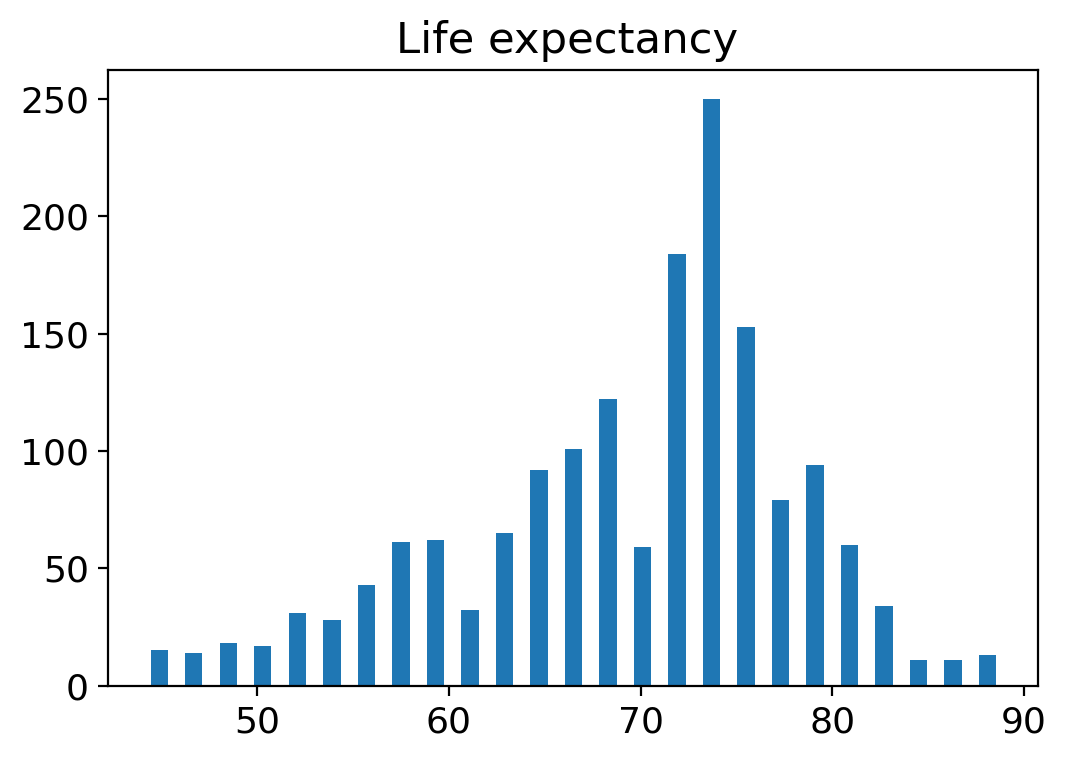

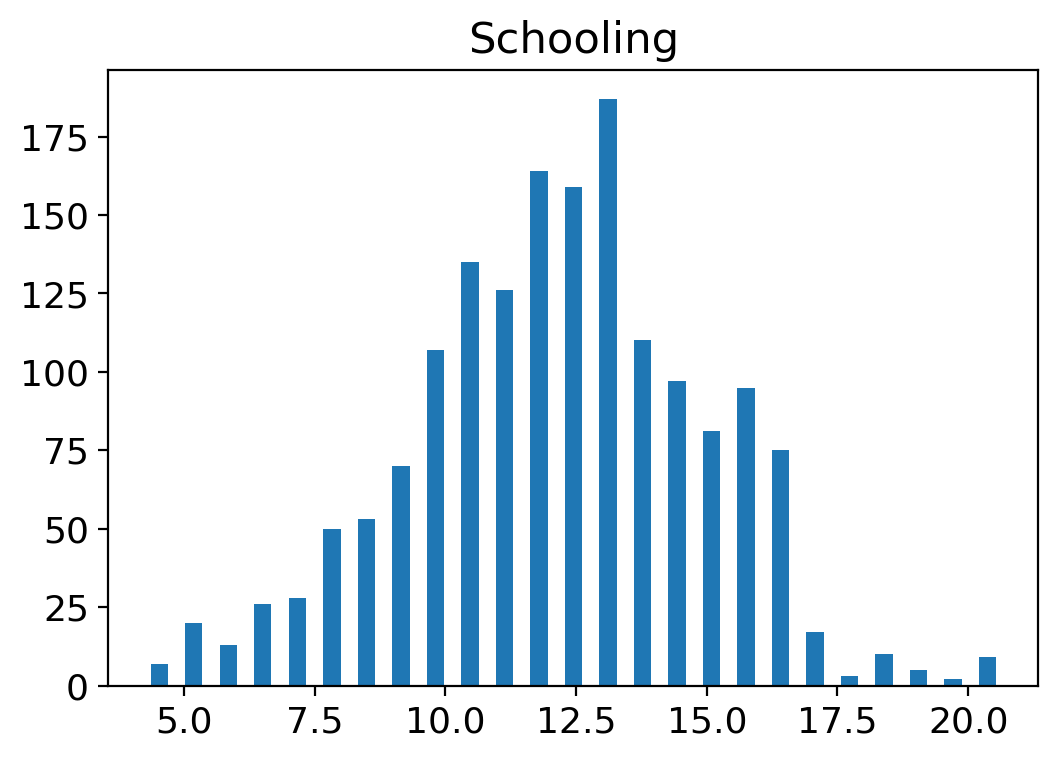

In [9]:
for col in ['Life expectancy ',"Schooling"]:
    plt.hist(df[col], bins=25, rwidth=0.5)
    plt.title(col)
    plt.show()

### 산포도

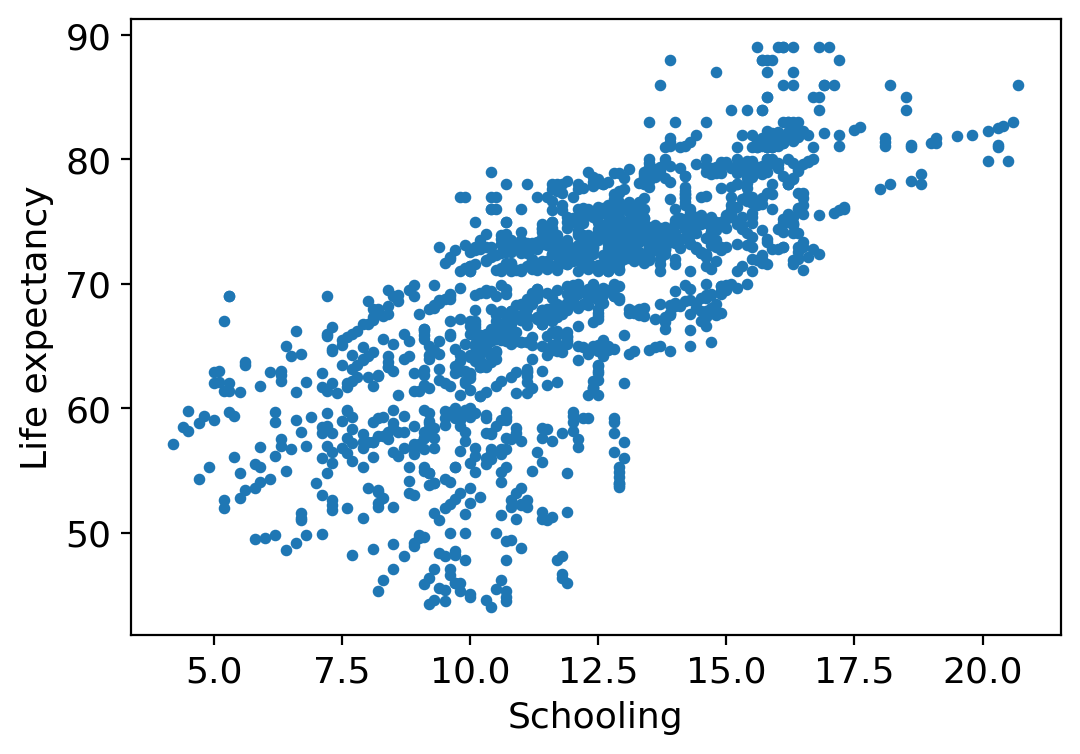

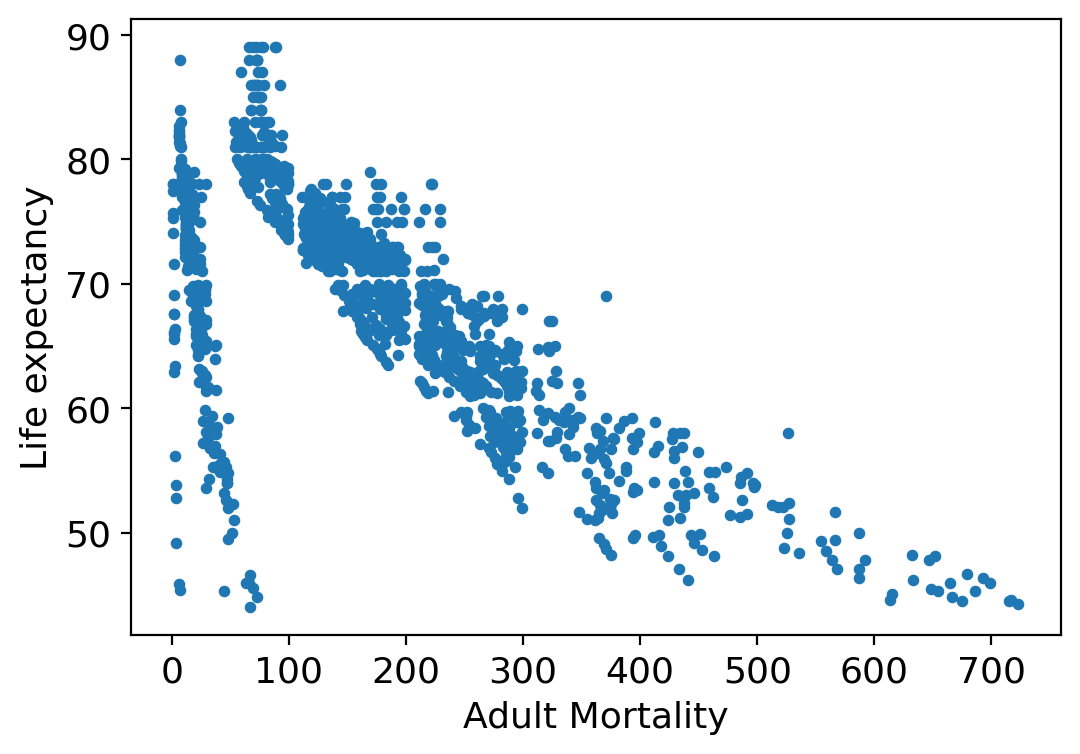

In [10]:
## 데이터 탐색 (산포도)

for col in ["Schooling", 'Adult Mortality']:
    plt.scatter(df[col] , df['Life expectancy '], s=10)
    plt.ylabel('Life expectancy')
    plt.xlabel(col)
    plt.show()

### 회귀 모델 성능 평가
- 회귀 모델의 성능을 평가하는 척도로 기본적으로 R-Squared를 사용하며 MAE, RMSE 등을 참고로 본다
 - MAE: mean absolute error  
 - MSE: mean squared error    
 - RMSE: root MSE  

$MAE = $$1\over{N}$$ \sum |y_{i} - \hat{y}|$

$MSE = $$1\over{N}$$ \sum (y_{i} - \hat{y})^{2}$

$RMSE = \sqrt{MSE}$

$R^{2} = 1$-$\sum(y_{i}-\hat{y})^{2}\over{\sum(y_{i}-\bar{y})^{2}}$ $= 1$-$MSE\over{Variance}$  
 >  $y$ :  실제값, $\hat{y}$ :  예측치, $\bar{y}$ :  평균치
 
-  R-Squared
 - 회귀 성능의 기본적인 평가 지표
 - MSE를 분산으로 정규화한 값을 사용한다
 - R-sqaured 값은 1에 가까울수록 완벽한 예측을 수행한 것이고, 0 근처이면 오차 평균치가 표준편차 정도인 경우이다

In [11]:
## 회귀 모델의 성능 평가 지표

# Maximum Error
# MAE: mean absolute error
# RMSE: root MSE
# R-Squared

def show_reg_result(y_test,y_pred):
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(3))

## 모든 변수를 사용 

- 다중 회귀 모델
 - 입력 변수가 2개인 다중회귀 모델이므로 파라미터가 변수의 수만큼 자동으로 2개 만들어진다
 - $\hat{y} = b +a_{1}x_{1} + a_{2}x_{2}$
 - $x_{1}$: 성별, $x_{2}$: 키

# 결과: 회귀결과 그래프

## 선형 계수

In [12]:
## 특성 중요도 보기

def plot_feature_weight(feature, weight):
    plt.figure(figsize=(5,8))
    W = pd.DataFrame({'feature':feature,'weight':weight})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

# 결정트리

- 결정 트리를 회귀모델에 사용할 때는 나누어지는 하위 두 그룹의 분산이 가능한 작아지도록 나눈다
 - 즉, 회귀 대상의 수치가 가능한 비슷한 샘플들이 모이도록 나눈다
- 결정 트리를 분류에 사용할 때는 크로스엔트로피 (또는 지니지수)가 가능한 작아지도록 나눈다
 - 즉, 나누어진 그룹에 같은 그룹의 샘플이 모이는 것을 측정하여 순도(purity)가 가능한 높아지도록 나눈다


In [14]:
## 훈련 데이터와 검증 데이터 준비

features = df.columns.difference(['Country','Life expectancy '])
X = df[features]
y = df["Life expectancy "]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9)

NameError: name 'train_test_split' is not defined

In [ ]:
## 결정 트리를 이용한 회귀 예측

# 최적의 트리 깊이 (max_depth)를 실험으로 찾는다
res = []
for depth in range(1,30):
    dtr = DecisionTreeRegressor(max_depth=depth) 
    dtr.fit(X_train, y_train) 
    res.append((depth, dtr.score(X_test, y_test).round(4))) 

df_res = pd.DataFrame(res, columns=['depth','R-squared']).set_index('depth')
print('depth: ',df_res.idxmax()[0], ', R-squared: ',df_res.max()[0])
df_res.plot()

In [ ]:
## 결정 트리 모델 성능 확인

dtr = DecisionTreeRegressor(max_depth=8)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)
show_reg_result(y_test,y_pred)

plot_feature_weight(X.columns, dtr.feature_importances_)

## 결정트리 보기

In [ ]:
## 결정트리 그리기

plt.figure(figsize=(22,12))

tree.plot_tree(dtr, fontsize=10,
              feature_names=X.columns,
              filled=True,
              impurity=True,
              max_depth=2)
plt.show()

In [ ]:
## 랜덤 포레스트를 이용한 회귀 예측

# 최적의 트리 깊이 (max_depth)를 실험으로 찾는다
res = []
for depth in range(1,30):
    rfr = RandomForestRegressor(max_depth=depth) 
    rfr.fit(X_train, y_train) 
    res.append((depth, rfr.score(X_test, y_test).round(4))) 

df_res = pd.DataFrame(res, columns=['depth','R-squared']).set_index('depth')
print('depth: ',df_res.idxmax()[0], ', R-squared: ',df_res.max()[0])
df_res.plot()

In [ ]:
## 랜덤 포레스트 모델 성능 확인

rfr = RandomForestRegressor(max_depth=13)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
show_reg_result(y_test,y_pred)

plot_feature_weight(X.columns, rfr.feature_importances_)

## 부스팅 (LightGBM)

- 설치가 안되어 있는 경우 아래와 같이 설치해야 함
- !conda install lightgbm -y

In [ ]:
## LightGBM 부스팅 모델을 이용한 회귀 예측

# 최적의 트리 깊이 (max_depth)를 실험으로 찾는다
res = []
for depth in range(1,30):
    lgbm_r = LGBMRegressor(max_depth=depth, num_leaves=32) 
    lgbm_r.fit(X_train, y_train, eval_set=(X_test, y_test), 
           early_stopping_rounds=5, verbose=False)
    res.append((depth, lgbm_r.score(X_test, y_test).round(4))) 

df_res = pd.DataFrame(res, columns=['depth','R-squared']).set_index('depth')
print('depth: ',df_res.idxmax()[0], ', R-squared: ',df_res.max()[0])
df_res.plot()

In [ ]:
## 부스팅 모델 성능 확인

lgbm_r = LGBMRegressor(max_depth=19, num_leaves=32)
lgbm_r.fit(X_train, y_train, eval_set=(X_test, y_test), 
           early_stopping_rounds=5, verbose=False)
y_pred = lgbm_r.predict(X_test)
show_reg_result(y_test,y_pred)

plot_feature_weight(X.columns, lgbm_r.feature_importances_)

In [ ]:
y_test

In [ ]:
## 회귀 예측과 실제값 샘플 비교하기

def plot_reg_result(y_test, y_pred, N=50):
    y_test = y_test.values
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.xlabel("Random Samples")
    plt.ylabel("Life Expectancy")
    plt.show()

y_pred = lgbm_r.predict(X_test)
plot_reg_result(y_test, y_pred)

## (참고) 오분류된 샘플 찾기

- 0(개발도상국)을 1(개발국)으로 잘 못 분류한 경우

In [ ]:
index_false = X_test[y_test < y_pred].index
print(index_false.size)
df.loc[index_false]

## (참고) 가장 성능이 좋은 3개의 특성 선택하기
- 임의로 3개의 특성을 선택했을 때 성능이 가능 좋은 경우가 언제인지 찾아보시오
- 선형모델 가중치가 큰 특성 고르기, 상관계수가 큰 특성 고르기, 특성중요도가 큰 특성 고르기를 각각 3개씩 선택하고 성능을 비교하시오
- 결정트리, 랜덤 포레스트, 부스팅 모델의 성능을 각각 구하시오 (총 9가지 경우의 성능 비교)

In [ ]:
X.columns

In [ ]:
# 세가지 경우에 대해서(선형계수, 상관계수, 특성중요도) 값이 큰 순으로 특성을 3개씩 선택했다.
feature_linear = ['infant deaths','under-five deaths ','Schooling']
feature_corr = ['Schooling','Income composition of resources', 'Adult Mortality']
feature_rfr = ['Income composition of resources',' HIV/AIDS', 'Adult Mortality']

for feature in [feature_linear, feature_corr, feature_rfr]:
    X_ft = X[feature]
    print(feature)
    X_train, X_test, y_train, y_test = train_test_split(X_ft, y)
    dtr.fit(X_train, y_train)
    print("DecisionTree Model:", dtr.score(X_test, y_test).round(3))
    rfr.fit(X_train, y_train)
    print("Random Forest Model:", rfr.score(X_test, y_test).round(3))
    lgbm_r.fit(X_train, y_train)
    print("Light GBM Model:", lgbm_r.score(X_test, y_test).round(3))
    print()